<font size="20"> Heart Disease </font>

INTRODUCTION:





PRELIMINARY EXPLORATORY DATA ANALYSIS:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read.csv(file = url) |>
rename(age=X63.0,
       sex=X1.0,
       chest_pain=X1.0.1,
       resting_blood_pressure=X145.0,
       cholesterol=X233.0,
       fasting_blood_sugar=X1.0.2,
       resting_electrocardiographic_results=X2.0,
       max_heart_rate=X150.0,
       exercise_induced_angina=X0.0,
       S_depression_induced=X2.3,
       slope_of_peak_exercise=X3.0,
       major_vessels=X0.0.1,
       thal=X6.0,
       heart_disease_diagnosis=X0)
heart_data


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


In [2]:
#Splitting data into training and testing
heart_split <- initial_split(heart_data, prop=0.75, strata=resting_blood_pressure)
    heart_train <- training(heart_split)
    heart_test <- testing(heart_split)

In [3]:
#Selected columns (sex, cholesterol and heart_disease_diagnosis) from heart data.
heart_train_selected <- select(heart_train, sex, age, cholesterol, resting_blood_pressure, heart_disease_diagnosis) |>
                        arrange(sex, cholesterol, age, resting_blood_pressure)
heart_train_selected

sex,age,cholesterol,resting_blood_pressure,heart_disease_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,71,149,112,0
0,45,160,112,0
0,62,164,160,3
0,46,177,142,0
0,60,178,120,0
0,35,183,138,0
0,52,196,136,0
0,58,197,130,0
0,63,197,124,1


In [16]:
count <- group_by(heart_train_selected, heart_disease_diagnosis) |>
            summarize(total=n())
count

heart_disease_diagnosis,total
<int>,<int>
0,126
1,41
2,26
3,23
4,8


In [5]:
#The table below reports the average cholesterol level for males(1) and females(0).
sex_vs_cholesterol <- group_by(heart_train_selected, sex) |>
                      summarize(cholesterol=mean(cholesterol, na.rm=TRUE))
sex_vs_cholesterol

sex,cholesterol
<dbl>,<dbl>
0,259.1389
1,239.7500


In [6]:
#The table below reports the average heart disease diagnosis (on a scale of 0-4) for males(1) and females(0).
sex_vs_heart_disease <- group_by(heart_train_selected, sex) |>
                        summarize(heart_disease_diagnosis=mean(heart_disease_diagnosis, na.rm=TRUE))
sex_vs_heart_disease

sex,heart_disease_diagnosis
<dbl>,<dbl>
0,0.5138889
1,1.0328947


In [7]:
#The table below reports the average cholesterol level for each heart disease diagnosis level (0-4).
heart_disease_vs_cholesterol <- group_by(heart_train_selected, heart_disease_diagnosis) |>
                                summarize(cholesterol=mean(cholesterol, na.rm=TRUE))
heart_disease_vs_cholesterol

heart_disease_diagnosis,cholesterol
<int>,<dbl>
0,240.8413
1,247.9756
2,272.2692
3,247.9130
4,225.7500


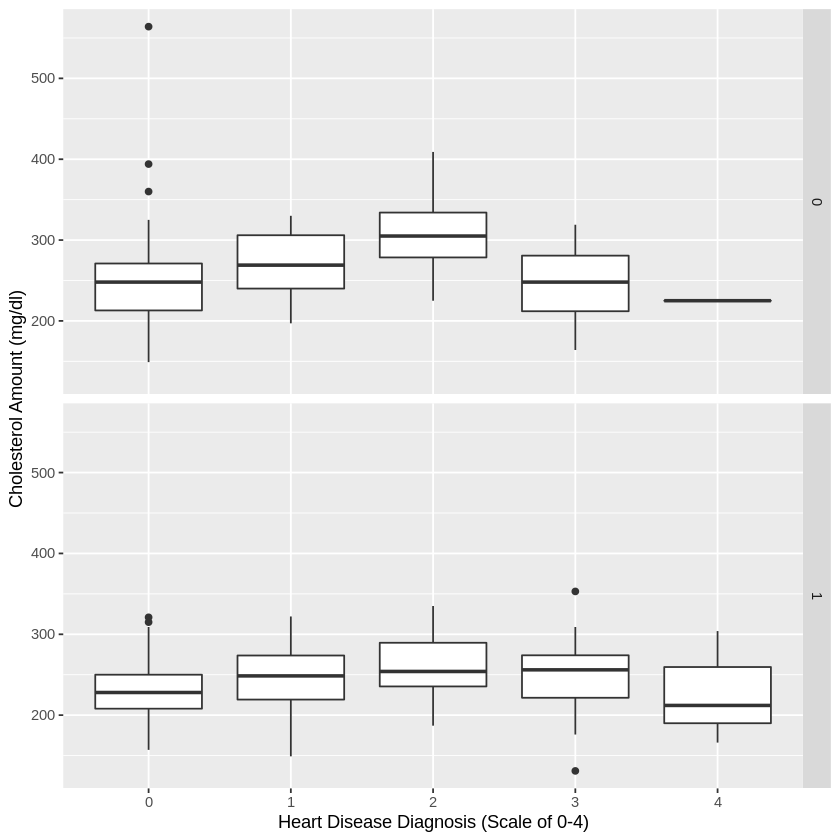

In [8]:
#Bar plot of heart disease level (0-4) vs cholesterol amount (mg/dl).
plot_heart_disease_vs_cholesterol <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=cholesterol)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Cholesterol Amount (mg/dl)")+
                            facet_grid(sex~.)
plot_heart_disease_vs_cholesterol

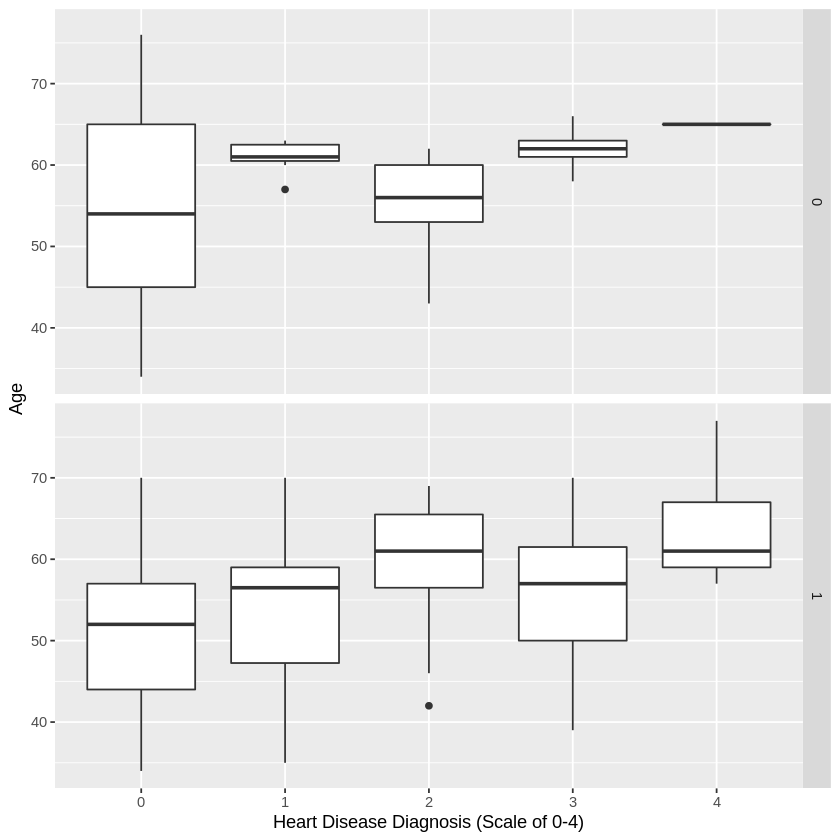

In [9]:
plot_heart_disease_vs_age <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=age)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Age")+
                            facet_grid(sex~.)
plot_heart_disease_vs_age

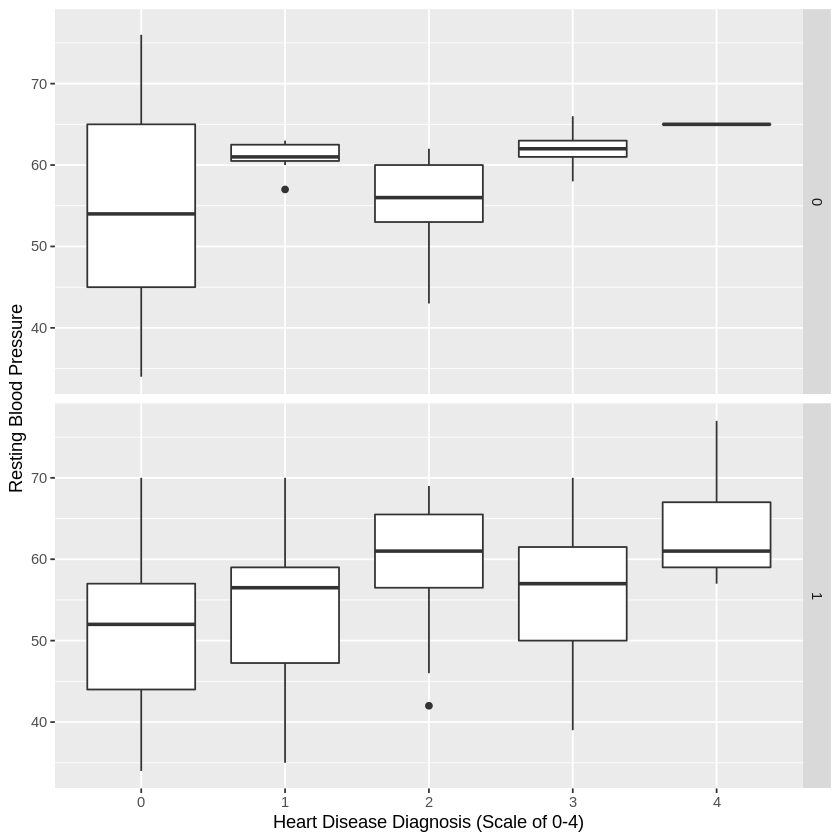

In [10]:
plot_heart_disease_vs_resting_blood_pressure <- heart_train_selected |>
                            mutate(heart_disease_diagnosis = as.factor(heart_disease_diagnosis)) |>
                            ggplot(aes(x=heart_disease_diagnosis, y=age)) +
                                 geom_boxplot() +
                                 labs(x="Heart Disease Diagnosis (Scale of 0-4)", y="Resting Blood Pressure")+
                            facet_grid(sex~.)
plot_heart_disease_vs_resting_blood_pressure

In [11]:
heart_train %>%
map_df(is.na) %>%
map_df(sum)


age,sex,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiographic_results,max_heart_rate,exercise_induced_angina,S_depression_induced,slope_of_peak_exercise,major_vessels,thal,heart_disease_diagnosis
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
nrow(heart_train)
nrow(heart_train %>% na.omit())

[1] 224

[1] 224

<font size="5"> Methods </font>

<font size="5"> Methods </font>